In [1]:
from utils.dataset import load_iris_dataset
import utils.helpers as helpers
import numpy as np

import matplotlib
import matplotlib.pyplot as plt

In [2]:
D, L = load_iris_dataset()
print("Shape of D:", D.shape)

Shape of D: (4, 150)


In [4]:
mu, C = helpers.compute_mu_C(D)
print(mu)

[[5.84333333]
 [3.05733333]
 [3.758     ]
 [1.19933333]]


### Center the data

In [8]:
DC = D - mu

### 🧮 Step 3: Compute the Covariance Matrix

Now that the data is centered, we can compute the covariance matrix using this expression:

```
C = (1 / N) * DC · DC^T
```

Where:
- `DC` is the centered data matrix, shape (4, 150)
- `N` is the number of samples (150)

This gives us a 4x4 covariance matrix.

In [9]:
N = D.shape[1]  # Number of samples = 150
# C = (1.0 / N) * np.dot(DC, DC.T)
C = DC @ DC.T / float(N)  # Alternative way to compute covariance matrix
print(C)

[[ 0.68112222 -0.04215111  1.26582     0.51282889]
 [-0.04215111  0.18871289 -0.32745867 -0.12082844]
 [ 1.26582    -0.32745867  3.09550267  1.286972  ]
 [ 0.51282889 -0.12082844  1.286972    0.57713289]]


### 🔢 Step 4: Eigen-decomposition for PCA

Now that we have the covariance matrix `C`, we want to extract its **eigenvalues and eigenvectors**.

Since the covariance matrix is symmetric, we’ll use the efficient NumPy function:

```python
s, U = np.linalg.eigh(C)
```

- `s` will contain the **eigenvalues**, sorted from smallest to largest.
- `U` will contain the **eigenvectors** as **columns** (shape will be 4x4).

But for PCA, we want the **top m eigenvectors**, ordered from **largest to smallest eigenvalue**.


In [10]:
# Compute eigenvalues and eigenvectors
s, U = np.linalg.eigh(C)

# Reverse the order (largest eigenvalue first)
P = U[:, ::-1]  # Now columns are sorted in descending order

# To get the projection matrix for the top m principal components:
m = 2
P_pca = P[:, :m]  # Shape: (4, m)

print("PCA projection matrix (first", m, "components):")
print(P_pca)


PCA projection matrix (first 2 components):
[[-0.36138659  0.65658877]
 [ 0.08452251  0.73016143]
 [-0.85667061 -0.17337266]
 [-0.3582892  -0.07548102]]


In [15]:
# Project the data onto the PCA space
DP = P_pca.T @ D

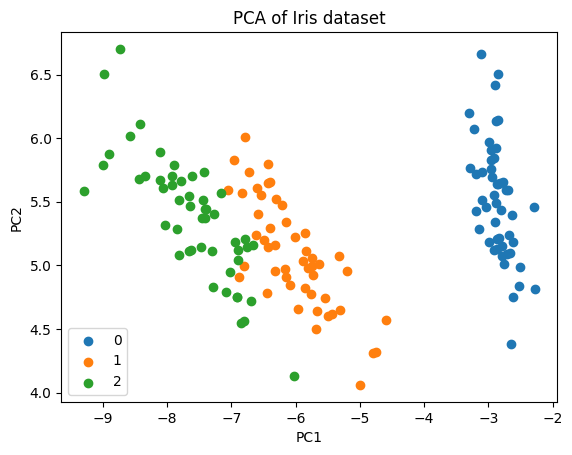

In [16]:
# Plot the PCA projection
plt.figure()
for i in range(3):
    plt.scatter(DP[0, L == i], DP[1, L == i], label = str(i))
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA of Iris dataset')
plt.legend()
plt.show()

# Linear Discriminant Analysis (LDA).
This part involves:
- Computing the within-class and between-class covariance matrices.
- Solving a generalized eigenvalue problem.
- Projecting the data onto the LDA subspace.

### 🔶 Step 6.1: Compute Class Means and Global Mean

We’ll loop through each class `c` (0, 1, 2 for IRIS) and compute:

- `mu`: global mean of all samples
- `mu_c`: mean of each class
- `D_c`: samples belonging to class `c`


In [3]:
K = len(np.unique(L))  # Number of classes
mu = helpers.vcol(D.mean(axis=1))
N = D.shape[1]
print(f"Number of classes: {K}, Global mean shape: \n{mu},\n Number of samples: {N}")

Number of classes: 3, Global mean shape: 
[[5.84333333]
 [3.05733333]
 [3.758     ]
 [1.19933333]],
 Number of samples: 150


### 🔷 Compute Within-Class Scatter Matrix `SW`

We compute:

```
SW = (1/N) * sum_c sum_i (x_i_c - mu_c)(x_i_c - mu_c)^T
```

In [4]:
SW = np.zeros((D.shape[0], D.shape[0]))

for c in range(K):
    D_c = D[:, L == c]
    mu_c = helpers.vcol(D_c.mean(axis=1))
    DC_c = D_c - mu_c
    SW += (1.0 / N) * np.dot(DC_c, DC_c.T)

In [5]:
print(SW)

[[0.259708   0.09086667 0.164164   0.03763333]
 [0.09086667 0.11308    0.05413867 0.032056  ]
 [0.164164   0.05413867 0.181484   0.041812  ]
 [0.03763333 0.032056   0.041812   0.041044  ]]


### 🔷 Compute Between-Class Scatter Matrix `SB`

We compute:

```
SB = (1/N) * sum_c n_c (mu_c - mu)(mu_c - mu)^T
```

In [14]:
SB = np.zeros((D.shape[0], D.shape[0]))

for c in range(K):
    D_c = D[:, L == c]
    mu_c = helpers.vcol(D_c.mean(axis=1))
    n_c = D_c.shape[1]
    SB += (n_c / N) * np.dot(mu_c - mu, (mu_c - mu).T)


In [15]:
print(SB)

[[ 0.42141422 -0.13301778  1.101656    0.47519556]
 [-0.13301778  0.07563289 -0.38159733 -0.15288444]
 [ 1.101656   -0.38159733  2.91401867  1.24516   ]
 [ 0.47519556 -0.15288444  1.24516     0.53608889]]


In [10]:
sb, sw = helpers.compute_Sb_Sw(D, L)

In [11]:
print(sw)

[[0.259708   0.09086667 0.164164   0.03763333]
 [0.09086667 0.11308    0.05413867 0.032056  ]
 [0.164164   0.05413867 0.181484   0.041812  ]
 [0.03763333 0.032056   0.041812   0.041044  ]]


### 🎯 Solve `SB w = λ SW w`

We’ll use `scipy.linalg.eigh`, which is designed for solving:

```
SB w = λ SW w
```


In [16]:
import scipy.linalg

s, U = scipy.linalg.eigh(sb, sw)

# Sort eigenvectors by descending eigenvalue
W = U[:, ::-1]  # Columns are LDA directions from most to least discriminant


In [17]:
print(W)

[[ 0.83779794  0.02434685 -2.19419846  2.35537895]
 [ 1.55005187  2.18649663  0.21771884 -2.70065485]
 [-2.22355955 -0.94138258  0.05611378 -3.04260698]
 [-2.83899363  2.86801283  1.87671964  4.20896389]]


In [18]:
# For IRIS (3 classes), the maximum number of LDA directions is K - 1 = 2.
m = 2
W_lda = W[:, :m]
print("W_lda shape:", W_lda.shape)


W_lda shape: (4, 2)


In [19]:
D_lda = np.dot(W_lda.T, D)


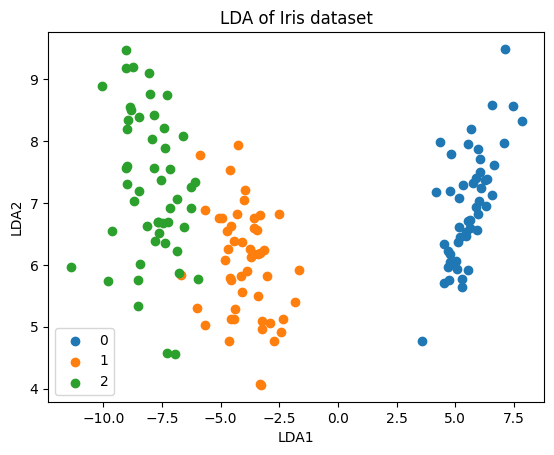

In [20]:
plt.figure()
for i in range(3):
    plt.scatter(D_lda[0, L == i], D_lda[1, L == i], label=str(i))
plt.xlabel('LDA1')
plt.ylabel('LDA2')
plt.title('LDA of Iris dataset')
plt.legend()
plt.show()
